   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.005923   1.094892   1.044975   0.183882  -0.716680  -1.132338   
1   0.167213   0.996617   1.264810   0.374348  -0.715217  -0.782484   
2   0.192684   1.330719   1.459489   0.534022  -0.242140  -0.549761   
3   0.607703   1.596154   1.732009   0.817367  -0.287919  -0.235158   
4   0.448847   1.519914   1.843187   0.819907  -0.081897  -0.125769   

   feature_7  feature_8  
0  -0.340279   1.075094  
1   0.335159   1.269869  
2   0.376962   1.566967  
3   0.772515   1.767502  
4   0.843078   1.796285  


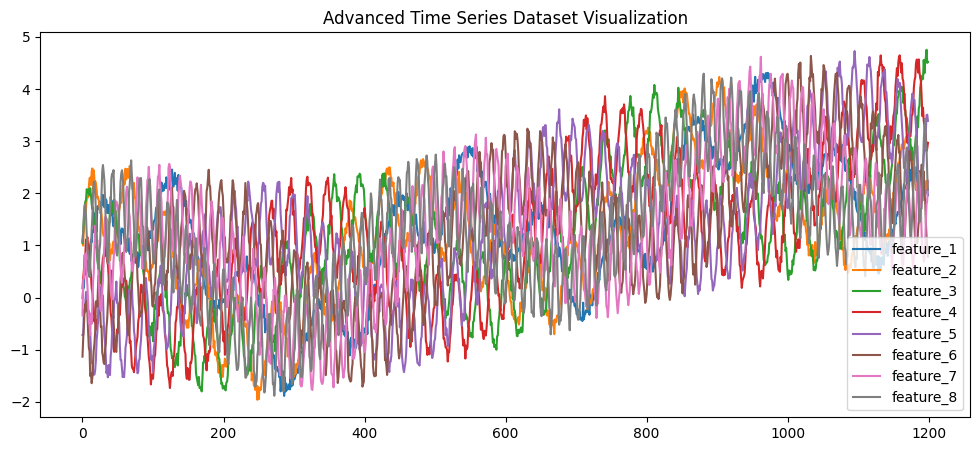


🔹 Training Transformer Model
Epoch 1 | Loss = 0.2260
Epoch 2 | Loss = 0.0741
Epoch 3 | Loss = 0.0541
Epoch 4 | Loss = 0.0458
Epoch 5 | Loss = 0.0392
Epoch 6 | Loss = 0.0356
Epoch 7 | Loss = 0.0334
Epoch 8 | Loss = 0.0320
Epoch 9 | Loss = 0.0289
Epoch 10 | Loss = 0.0289

🔹 Training LSTM Baseline
Epoch 1 | Loss = 0.7108
Epoch 2 | Loss = 0.2930
Epoch 3 | Loss = 0.1775
Epoch 4 | Loss = 0.1586
Epoch 5 | Loss = 0.1479
Epoch 6 | Loss = 0.1373
Epoch 7 | Loss = 0.1236
Epoch 8 | Loss = 0.1098
Epoch 9 | Loss = 0.0937
Epoch 10 | Loss = 0.0792

Transformer Results
MSE : 0.04498135
RMSE: 0.21208806
MAE : 0.16823162

LSTM Results
MSE : 0.14599065
RMSE: 0.38208723
MAE : 0.3091957


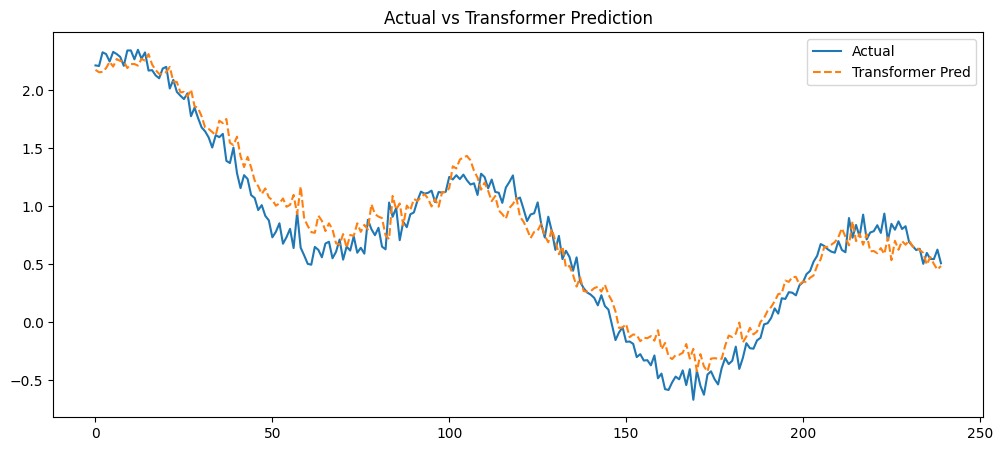

In [11]:
#Import Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Load dataset
df = pd.read_csv("/content/sample_data/advanced_timeseries_dataset.csv")
data = df.values
print(df.head())

#Visualization datset before
plt.figure(figsize=(12,5))
for col in df.columns:
    plt.plot(df[col], label=col)

plt.title("Advanced Time Series Dataset Visualization")
plt.legend()
plt.show()

#Normalization
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

#Create a sliding windows
class WindowDataset(Dataset):
    def __init__(self, data, seq_len=50):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_len = 50
train_size = int(0.8 * len(data_scaled))

train_ds = WindowDataset(data_scaled[:train_size], seq_len)
test_ds = WindowDataset(data_scaled[train_size-seq_len:], seq_len)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

#simple transfer model
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, n_heads=4, layers=2):
        super().__init__()
        self.input = nn.Linear(input_dim, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.fc = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.input(x)
        x = self.encoder(x)
        return self.fc(x[:, -1])

#Baseline LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, input_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

#Train function
def train(model, loader, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        losses = []
        for x, y in loader:
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        print(f"Epoch {epoch+1} | Loss = {np.mean(losses):.4f}")

#Train transformer & LSTM
input_dim = data.shape[1]

transformer = SimpleTransformer(input_dim)
lstm = SimpleLSTM(input_dim)

print("\n🔹 Training Transformer Model")
train(transformer, train_dl, epochs=10)

print("\n🔹 Training LSTM Baseline")
train(lstm, train_dl, epochs=10)

#Evaluation Function
def evaluate(model, loader):
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            out = model(x).numpy()
            preds.append(out)
            trues.append(y.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    mse = np.mean((preds - trues)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(preds - trues))
    return preds, trues, mse, rmse, mae

#Run Evaluation
t_pred, t_true, t_mse, t_rmse, t_mae = evaluate(transformer, test_dl)
l_pred, l_true, l_mse, l_rmse, l_mae = evaluate(lstm, test_dl)

print("\nTransformer Results")
print("MSE :", t_mse)
print("RMSE:", t_rmse)
print("MAE :", t_mae)

print("\nLSTM Results")
print("MSE :", l_mse)
print("RMSE:", l_rmse)
print("MAE :", l_mae)

#Plot Predictions
plt.figure(figsize=(12,5))
plt.plot(t_true[:,0], label="Actual")
plt.plot(t_pred[:,0], label="Transformer Pred", linestyle="--")
plt.legend()
plt.title("Actual vs Transformer Prediction")
plt.show()
